<br><font color='green'>
## ch.4 Libraries, Read data(1)

In [1]:
# basic 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)
from itertools import combinations

# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#  tf.logging.set_verbosity(tf.logging.ERROR) <- logging이 버전업그레이드에서 사용 X라함

# from tensorflow import set_random_seed 
# 위에 코드 안됨에 대한 답변: In Tensoflow2 there is no need to perform
# from tensorflow import set_random_seed
# in order to run
# set_random_seed(x)
# (as it was in older version)
# Only have to run
# import tensorflow
# tensorflow.random.set_seed(x)

tf.random.set_seed(2020)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot

Using TensorFlow backend.


### Read Data

In [2]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

df_train.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000


### Transform Categorical Data using BOW

In [3]:
level = 'gds_grp_nm'

df_all = pd.concat([df_train, df_test])
train1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test1 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'gds_grp_mclas_nm'

df_all = pd.concat([df_train, df_test])
train2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test2 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

level = 'goods_id'

df_all = pd.concat([df_train, df_test])
train3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id not in @IDtest'). \
                         drop(columns=['cust_id']).values
test3 = pd.pivot_table(df_all, index='cust_id', columns=level, values='amount',
                         aggfunc=lambda x: np.where(len(x) >=1, 1, 0), fill_value=0). \
                         reset_index(). \
                         query('cust_id in @IDtest'). \
                         drop(columns=['cust_id']).values

train = np.hstack([train1, train2, train3])
test = np.hstack([test1, test2, test3])

train.shape, test.shape

((3500, 4179), (2482, 4179))

In [4]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

train.shape, test.shape

((3500, 4179), (2482, 4179))

In [5]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,4154,4155,4156,4157,4158,4159,4160,4161,4162,4163,4164,4165,4166,4167,4168,4169,4170,4171,4172,4173,4174,4175,4176,4177,4178
0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3496,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3497,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,4154,4155,4156,4157,4158,4159,4160,4161,4162,4163,4164,4165,4166,4167,4168,4169,4170,4171,4172,4173,4174,4175,4176,4177,4178
0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2478,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2479,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2480,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# w2v 피쳐

In [7]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()

In [8]:
### Make corpus
p_level = 'gds_grp_mclas_nm'  # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 n배 oversampling을 수행
# unique 사용하지 않음.

def oversample(x, n=1, seed=0):   
    np.random.seed(seed)
    ids = x['cust_id'].unique().tolist() 
    Products = []
    
    for id_s in ids:    
        productList = x.query(f'cust_id == {id_s}')[p_level].tolist()
        for i in range(n):
            productList = list(np.append(productList, np.random.choice(productList, len(productList)*n, replace=True)))  # 복원추출 사용.
        Products.append(productList)
    return Products

X_train = oversample(df_train, 2)
X_test = oversample(df_test, 2)

### Training the Word2Vec model
num_features = 300 # 단어 벡터 차원 수
min_word_count = 1 # 최소 단어 수
context = 10 # 학습 윈도우(인접한 단어 리스트) 크기

# 초기화 및 모델 학습
from gensim.models import word2vec

W2V_train = pd.concat([X_train, X_test])

# 모델 학습
w2v = word2vec.Word2Vec(X_train, 
                        size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        sg=1, # sg=1, workers=4 사용. sg=1 로 skip-gram방식 채택
                        seed=0, workers=4)
# 필요없는 메모리 unload
w2v.init_sims(replace=True)

### Make features
# 구매상품에 해당하는 벡터의 최대/분산/표준편차 벡터를 feature로 만드는 전처리기(pipeline에서 사용 가능)
class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = num_features
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.hstack([
                np.max([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.std([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0),
                np.var([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)                
            ]) 
            for words in X
        ])  
    
# EmbeddingVectorizer 클래스를 통해서 피쳐뽑기

Vectorizer = EmbeddingVectorizer(w2v.wv)
Vectorizer.fit(X_train, y_train)

X_train_new = pd.DataFrame(Vectorizer.transform(X_train))
X_test_new = pd.DataFrame(Vectorizer.transform(X_test))

X_train_new

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899
0,0.214500,0.206771,0.062059,0.238814,0.166615,-0.023256,0.110079,0.207877,0.117506,0.171348,0.120668,0.108240,0.142698,0.055262,0.165987,0.112420,0.043088,-0.068008,0.195230,0.170338,0.029458,0.055783,0.056435,0.070049,0.097454,...,1.019264e-03,2.194041e-03,4.921370e-04,0.001799,0.000525,2.541245e-04,1.121184e-03,2.343899e-03,0.001800,1.753036e-03,3.363838e-03,0.001370,0.003340,2.236529e-03,1.542653e-03,2.786307e-03,8.959803e-04,1.043417e-03,7.144941e-04,3.305470e-03,1.044831e-03,1.379269e-03,1.673189e-03,6.529198e-04,3.083412e-03
1,0.015711,0.062730,-0.043520,0.162980,-0.001396,-0.047237,0.140842,0.027632,0.104925,0.072827,0.100467,0.010744,0.049292,0.028019,0.105775,0.059920,-0.075138,-0.024482,0.157721,0.040866,0.000605,0.024737,0.067505,0.035784,0.136009,...,1.090957e-03,4.160779e-05,2.709687e-06,0.000401,0.000138,8.654832e-05,4.782922e-04,3.565023e-05,0.000147,4.212940e-04,1.839510e-04,0.000559,0.001318,8.341083e-05,3.318587e-04,4.050342e-03,1.241258e-03,2.591339e-04,1.701021e-07,1.075745e-03,2.230564e-04,6.229517e-04,2.913376e-04,6.351739e-05,8.040621e-04
2,-0.015932,0.127099,0.060510,0.059193,0.082374,-0.137578,0.023619,0.142267,0.106798,0.173249,0.059686,0.037652,0.081795,-0.045903,0.107647,0.034392,-0.035369,-0.083618,0.119715,0.122807,-0.055677,-0.014993,0.018725,-0.055801,0.068883,...,2.626336e-04,6.525872e-04,1.063765e-03,0.003230,0.000597,1.349225e-04,1.272191e-04,1.254974e-04,0.001900,5.465227e-04,2.435525e-03,0.000847,0.000084,1.234864e-04,6.376922e-04,3.543739e-06,1.866656e-03,3.042340e-04,1.788292e-04,9.827006e-04,5.217295e-04,1.140316e-04,7.076831e-04,2.407963e-06,6.393470e-03
3,0.061112,0.154204,0.086957,0.131966,0.143496,0.088738,0.187550,0.015053,0.052729,0.165695,0.110844,0.108240,0.117168,0.072764,0.174060,0.113033,0.043088,-0.026158,0.226600,0.136816,0.040021,0.026174,0.040738,0.078009,0.144696,...,1.275818e-04,5.847163e-04,3.698890e-04,0.000584,0.000228,2.496884e-04,1.759198e-04,7.960545e-04,0.000970,7.354626e-04,1.530466e-03,0.000563,0.000671,1.552071e-03,7.705090e-04,1.649934e-03,9.552732e-04,4.261676e-04,1.380861e-04,2.693030e-03,7.930224e-04,1.272590e-03,8.224003e-04,9.317662e-04,3.330565e-03
4,0.022751,0.063527,0.007839,0.116731,0.166615,-0.110768,0.023619,-0.116240,0.018087,0.125321,0.059686,0.037652,0.096700,0.061061,0.143899,0.100375,-0.013169,-0.082569,0.195230,0.122807,0.009113,-0.037046,0.028868,0.022995,0.116345,...,5.559274e-05,2.979089e-03,5.774139e-04,0.002427,0.000082,4.948785e-06,9.064630e-04,1.922829e-03,0.001282,3.378957e-05,3.771307e-03,0.001034,0.002082,4.732637e-04,4.501117e-04,2.998665e-03,1.463594e-03,7.593695e-04,6.581688e-05,1.748645e-03,1.275100e-03,2.857581e-04,1.678091e-04,1.107783e-03,2.282339e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,-0.024489,0.062400,-0.078438,0.166564,0.082374,-0.099936,0.052247,0.092031,0.018087,0.125321,0.059686,0.037652,0.081795,-0.045903,0.114961,0.057411,-0.051204,-0.068008,0.083965,0.122807,-0.025192,0.041152,0.018725,-0.055801,0.068883,...,3.359791e-04,3.755260e-04,1.475495e-06,0.000439,0.000844,4.671574e-04,2.366442e-05,1.661410e-04,0.000197,2.876954e-05,1.355283e-03,0.000494,0.000137,1.464917e-04,3.309719e-04,6.739005e-04,1.059248e-04,1.743778e-03,4.900650e-05,9.096746e-04,1.915550e-05,2.367370e-04,3.312935e-04,1.809499e-04,1.495713e-03
3496,-0.024489,0.128795,0.062059,0.177221,0.091639,-0.030054,0.110079,0.092031,0.117506,0.171348,0.084820,0.037652,0.081795,0.034215,0.114961,0.078798,0.002925,-0.064199,0.196836,0.122807,0.040021,0.041152,0.018725,0.026319,0.068883,...,2.066605e-04,2.265544e-04,1.923648e-04,0.000222,0.000626,2.318979e-04,3.933502e-04,2.781476e-03,0.000306,3.344019e-03,3.253693e-03,0.0005

In [9]:
### Read data

df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv')
IDtest = df_test.cust_id.unique()


y_train.gender = y_train.gender.astype(str)

tr = pd.merge(df_train, y_train, on='cust_id')
tr2 = pd.concat([df_train, df_test])

corpus_goods = []
corpus_nm = []
corpus_mclas = []

for i in range(len(tr)):
    
    goods = tr.loc[i, 'goods_id']
    nm = tr.loc[i, 'gds_grp_nm']
    mclas = tr.loc[i, 'gds_grp_mclas_nm']
    gen = tr.loc[i, 'gender']
    
    corpus_goods.append([goods, gen])
    corpus_nm.append([nm, gen])
    corpus_mclas.append([mclas, gen])
    
tr['corpus_goods'] = corpus_goods
tr['corpus_nm'] = corpus_nm
tr['corpus_mclas'] = corpus_mclas

corpus_df = pd.DataFrame(tr.groupby('cust_id')['corpus_goods'].agg(lambda x: [j for i in x for j in i]))
corpus_df['corpus_nm'] = tr.groupby('cust_id')['corpus_nm'].agg(lambda x: [j for i in x for j in i])
corpus_df['corpus_mclas'] = tr.groupby('cust_id')['corpus_mclas'].agg(lambda x: [j for i in x for j in i])

display(corpus_df)

corpus1 = corpus_df['corpus_goods']
corpus2 = corpus_df['corpus_nm']
corpus3 = corpus_df['corpus_mclas']

def oversample2(data, n=1, seed=0):    
    
    np.random.seed(seed)
    
    customerProducts = []
    
    for cor in data:
            
        cor = list(np.append(cor, np.random.choice(cor, len(cor) * n, replace=True)))
        
        customerProducts.append(cor)
    
    return customerProducts

corpus1_sam = oversample2(corpus1, n=20, seed=0)
corpus2_sam = oversample2(corpus2, n=20, seed=0)
corpus3_sam = oversample2(corpus3, n=20, seed=0)

# W2V 학습

num_features = 20 # 문자 벡터 차원 수
min_word_count = 0 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 3 # 문자열 창 크기

wv_item1 = word2vec.Word2Vec(corpus1_sam, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context)

wv_item2 = word2vec.Word2Vec(corpus2_sam, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context)

wv_item3 = word2vec.Word2Vec(corpus3_sam, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context)

## goods_id

def get_0_similarity_goods(product):
    try:
        sim = wv_item1.similarity('0', f'{product}')
    except:
        sim = np.nan
    return sim

def get_1_similarity_goods(product):
    try:
        sim = wv_item1.similarity('1', f'{product}')
    except:
        sim = np.nan
    return sim

## gds_grp_nm

def get_0_similarity_nm(product):
    try:
        sim = wv_item2.similarity('0', f'{product}')
    except:
        sim = np.nan
    return sim

def get_1_similarity_nm(product):
    try:
        sim = wv_item2.similarity('1', f'{product}')
    except:
        sim = np.nan
    return sim

## gds_grp_mclas_nm

def get_0_similarity_mclas(product):
    try:
        sim = wv_item3.similarity('0', f'{product}')
    except:
        sim = np.nan
    return sim

def get_1_similarity_mclas(product):
    try:
        sim = wv_item3.similarity('1', f'{product}')
    except:
        sim = np.nan
    return sim


tr2['goods_0_similarity'] = tr2['goods_id'].apply(get_0_similarity_goods)
tr2['goods_1_similarity'] = tr2['goods_id'].apply(get_1_similarity_goods)
tr2['nm_0_similarity'] = tr2['gds_grp_nm'].apply(get_0_similarity_nm)
tr2['nm_1_similarity'] = tr2['gds_grp_nm'].apply(get_1_similarity_nm)
tr2['mclas_0_similarity'] = tr2['gds_grp_mclas_nm'].apply(get_0_similarity_mclas)
tr2['mclas_1_similarity'] = tr2['gds_grp_mclas_nm'].apply(get_1_similarity_mclas)

train_test = pd.DataFrame({'cust_id' : range(5982)}).set_index('cust_id')

train_test['goods_0_similarity'] = tr2.groupby('cust_id')['goods_0_similarity'].apply(lambda x: np.nanmean(x))
train_test['goods_1_similarity'] = tr2.groupby('cust_id')['goods_1_similarity'].apply(lambda x: np.nanmean(x))
train_test['nm_0_similarity'] = tr2.groupby('cust_id')['nm_0_similarity'].apply(lambda x: np.nanmean(x))
train_test['nm_1_similarity'] = tr2.groupby('cust_id')['nm_1_similarity'].apply(lambda x: np.nanmean(x))
train_test['mclas_0_similarity'] = tr2.groupby('cust_id')['mclas_0_similarity'].apply(lambda x: np.nanmean(x))
train_test['mclas_1_similarity'] = tr2.groupby('cust_id')['mclas_1_similarity'].apply(lambda x: np.nanmean(x))


X_train_w2v = train_test[:3500]
X_test_w2v = train_test[3500:]

idx = [i for i in range(3500,5982)]

X_test_new['cust_id'] = idx
X_test_new = X_test_new.set_index('cust_id')

X_train_new = pd.concat([X_train_w2v, X_train_new], axis=1)
X_test_new = pd.concat([X_test_w2v, X_test_new], axis=1)
X_test_new = X_test_new.fillna(X_test_new.mean())

,corpus_goods,corpus_nm,corpus_mclas
cust_id,,,
0,"[127105, 0, 342220, 0, 127105, 0, 342205, 0, 3...","[기초 화장품, 0, 니 트, 0, 기초 화장품, 0, 니 트, 0, 상품군미지...","[화장품, 0, 시티웨어, 0, 화장품, 0, 시티웨어, 0, 기타, 0, 화장품,..."
1,"[550231, 0, 550231, 0, 462102, 0]","[아웃도아, 0, 아웃도아, 0, 트래디셔널Ⅰ, 0]","[스포츠, 0, 스포츠, 0, 트래디셔널, 0]"
2,"[461119, 1, 461119, 1, 461119, 1, 461119, 1]","[시티캐주얼, 1, 상품군미지정, 1, 상품군미지정, 1, 시티캐주얼, 1]","[남성 캐주얼, 1, 기타, 1, 기타, 1, 남성 캐주얼, 1]"
3,"[35145, 1, 821104, 1, 32263, 1, 50114, 1, 5010...","[회, 1, 한실침구, 1, 생선, 1, 일반가공식품, 1, 일반가공식품, 1, 일...","[수산품, 1, 침구/수예, 1, 수산품, 1, 가공식품, 1, 가공식품, 1, 가..."
4,"[127109, 0, 150124, 0, 150124, 0]","[기초 화장품, 0, 상품군미지정, 0, 보석, 0]","[화장품, 0, 기타, 0, 보석, 0]"
...,...,...,...
3495,"[143102, 1, 143102, 1]","[L/C골프의류, 1, 상품군미지정, 1]","[골프, 1, 기타, 1]"
3496,"[405107, 1, 173197, 1, 381116, 1, 996101, 1, 3...","[N.B정장, 1, 캐릭터 여화, 1, 시니어, 1, 상품군미지정, 1, 인텔리젼스...","[남성정장, 1, 구두, 1, 시티웨어, 1, 기타, 1, 시티웨어, 1, 시티웨어..."
3497,"[647178, 0]","[국산주방, 0]","[주방용품, 0]"


In [10]:
y_train = y_train.gender

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [04:52<00:00,  3.08s/it]
No handles with labels found to put in legend.


LogisticRegression (99, 0.7631489584377122)


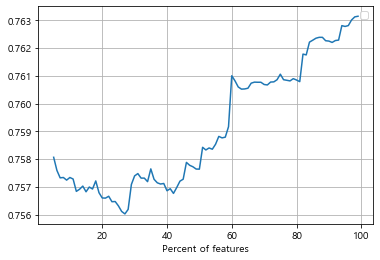

In [11]:
logreg = LogisticRegression(random_state=0, n_jobs=-1)

models = [logreg]

skf = StratifiedKFold(n_splits=4 , shuffle=False, random_state=50)

# 6개의 모델을 이용해서 가장 잘나온 p를 뽑을 것임
for model in models:
    
    cv_scores = []
    
    # 퍼센타일을 5~100프로 모두 살피기 <- 처음에만 100프로 찍고 이후 조절하기
    for percentile in tqdm(range(5,100)):
    
        X_new = SelectPercentile(percentile = percentile).fit_transform(X_train_new,y_train)
       
        # cross_val_score 4번의 평균값 (정수시 skf로 자동으로 들어간다)
        cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=skf).mean()
        
        cv_scores.append((percentile, cv_score))
        
    # 베스트 percentile과 점수 출력
    best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
    print(model.__class__.__name__, best_score)
    
    # 모델별 percentile에 따른 성능 그림
    plt.plot([p for p,_ in cv_scores], [score for _, score in cv_scores])
    plt.xlabel('Percent of features')
    plt.legend(loc=0)
    plt.grid()

In [12]:
select_p = SelectPercentile(percentile=best_score[0]).fit(X_train_new, y_train)
X_train = select_p.transform(X_train_new)
X_test = select_p.transform(X_test_new)

In [13]:
train1 = pd.DataFrame(X_train)
test1 = pd.DataFrame(X_test)

In [14]:
train = pd.concat([train, train1], axis=1)
test = pd.concat([test, test1], axis=1)

In [16]:
X_train_41 = pd.read_csv('X_train_after_preprocessing41.csv',encoding='cp949')
X_test_41 = pd.read_csv('X_test_after_preprocessing41.csv', encoding='cp949')
IDtest = df_test.cust_id.unique()
y_train = pd.read_csv('y_train.csv').gender


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

DNN learning curve 1/15


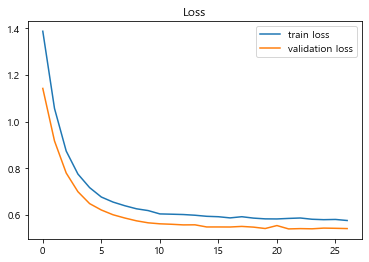

AUC 0.8048752981999566



  7%|█████▍                                                                            | 1/15 [01:54<26:42, 114.47s/it]

DNN learning curve 2/15


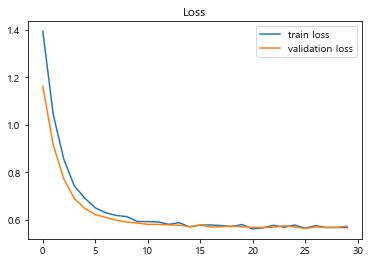


 13%|███████████                                                                        | 2/15 [02:14<18:39, 86.09s/it]

AUC 0.7766611977030352
DNN learning curve 3/15


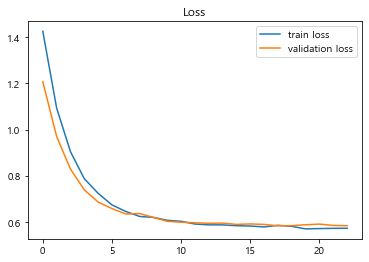


 20%|████████████████▌                                                                  | 3/15 [02:36<13:24, 67.01s/it]

AUC 0.7613128479639018
DNN learning curve 4/15


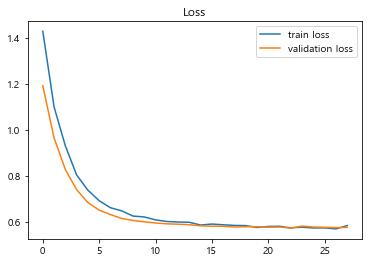


 27%|██████████████████████▏                                                            | 4/15 [02:58<09:47, 53.39s/it]

AUC 0.7530293367346939
DNN learning curve 5/15


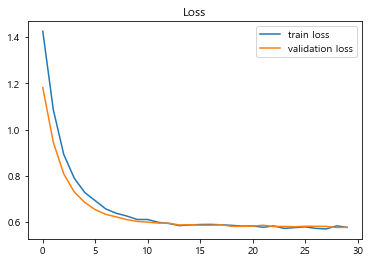


 33%|███████████████████████████▋                                                       | 5/15 [03:19<07:16, 43.68s/it]

AUC 0.754459776374384
DNN learning curve 6/15


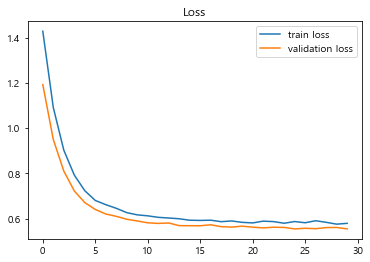

AUC 0.7798133333333332


 40%|█████████████████████████████████▏                                                 | 6/15 [03:40<05:33, 37.02s/it]

DNN learning curve 7/15


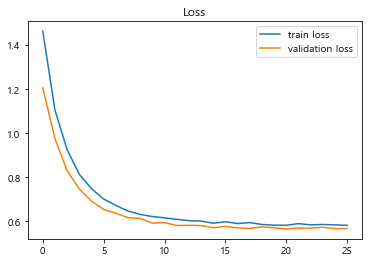


 47%|██████████████████████████████████████▋                                            | 7/15 [04:02<04:19, 32.50s/it]

AUC 0.7692831436630678
DNN learning curve 8/15


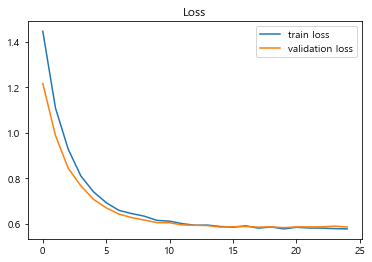


 53%|████████████████████████████████████████████▎                                      | 8/15 [04:24<03:23, 29.08s/it]

AUC 0.760841032503796
DNN learning curve 9/15


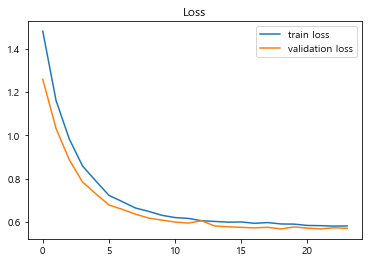


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [04:44<02:39, 26.63s/it]

AUC 0.7742757334594069
DNN learning curve 10/15


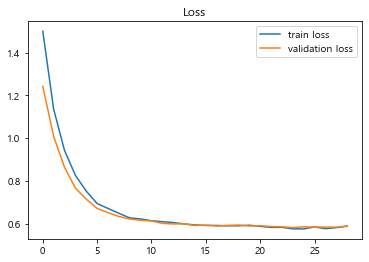

AUC 0.761993546684375



 67%|██████████████████████████████████████████████████████▋                           | 10/15 [05:05<02:04, 24.90s/it]

DNN learning curve 11/15


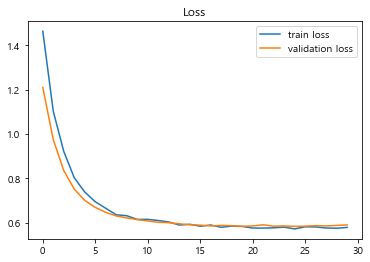


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [05:26<01:34, 23.56s/it]

AUC 0.7476689517505843
DNN learning curve 12/15


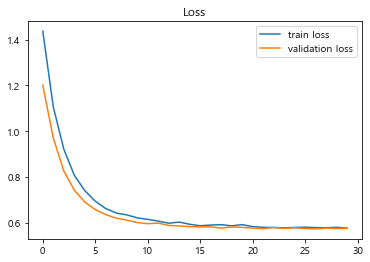

AUC 0.761896006793966



 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [05:46<01:08, 22.70s/it]

DNN learning curve 13/15


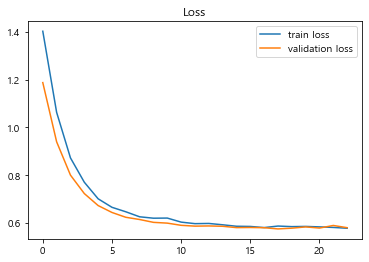


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [06:10<00:45, 22.94s/it]

AUC 0.7681914540392818
DNN learning curve 14/15


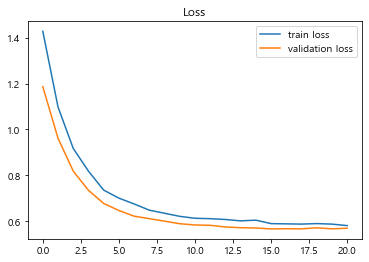

AUC


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [06:33<00:23, 23.09s/it]

 0.7727097902097902
DNN learning curve 15/15


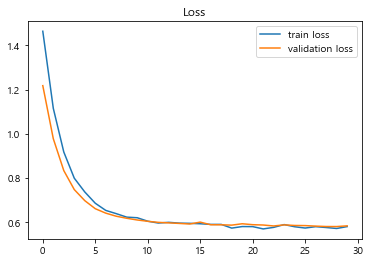

AUC 0.7515212005007923



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [06:57<00:00, 27.82s/it]


Validation Summary:
0     0.804875
5     0.779813
1     0.776661
8     0.774276
13    0.772710
6     0.769283
12    0.768191
9     0.761994
11    0.761896
2     0.761313
7     0.760841
4     0.754460
3     0.753029
14    0.751521
10    0.747669
dtype: float64
mean=0.76657, std=0.014


In [38]:
X_train, X_test = train, test

# Set hyper-parameters for power mean ensemble 
N = 15
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):
    ##### STEP 1: Randomize Seed
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    ##### STEP 2: Build DAE #####

    # Define the encoder dimension
    encoding_dim = 128

    # Input Layer
    input_dim = Input(shape = (X_train.shape[1], ))

    # Encoder Layers
    noise = Dropout(0.5)(input_dim) # for Denoising
    encoded1 = Dense(512, activation = 'relu')(noise)
    encoded2 = Dense(256, activation = 'relu')(encoded1)
    encoded3 = Dense(128, activation = 'relu')(encoded2)
    encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

    # Decoder Layers
    decoded1 = Dense(128, activation = 'relu')(encoded4)
    decoded2 = Dense(256, activation = 'relu')(decoded1)
    decoded3 = Dense(512, activation = 'relu')(decoded2)
    decoded4 = Dense(X_train.shape[1], activation = 'linear')(decoded3)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded4)

    # Compile the model
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, 
                        shuffle=True, validation_data=(X_test,X_test), verbose=0)

#     print(f'DAE learning curve {i+1}')
#     plt.plot(history.history["loss"], label="train loss")
#     plt.plot(history.history["val_loss"], label="validation loss")
#     plt.legend()
#     plt.title("Loss")
#     plt.show()

    ##### STEP 3: Reduce Dimension #####

    # Use a middle Bottleneck Layer to Reduce Dimension
    model = Model(inputs=input_dim, outputs=encoded4)
    X_train = model.predict(X_train)
    X_test = model.predict(X_test)
    
    # < DAE 128 features + 41 percentile numbercial features >
    X_train = pd.concat([pd.DataFrame(X_train), X_train_41], axis=1)
    X_test = pd.concat([pd.DataFrame(X_test), X_test_41], axis=1)
    

    ##### STEP 4: Build a DNN Model

    # Define the Model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.6))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(1, activation='sigmoid'))

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)
    history = model.fit(train_x, train_y, epochs=30, batch_size=64, 
                        validation_data=(valid_x,valid_y), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)], verbose=0)

    print(f'DNN learning curve {i+1}/{N}')
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    # Make Prediction
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())   

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))   

In [43]:
N = 15
p = [2.56, 3.5, 4.5]
for j in p:
    # Power mean ensemble
    THRESHOLD = 0.8  # Use only models whose AUC exceeds this value

    pred = 0
    n = 0
    for i in range(N):
        if aucs.iloc[i] > THRESHOLD:
            pred = pred + preds[i]**j
            n += 1
    pred = pred / n    
    pred = pred**(1/j)

    # Make a submission file
    t = pd.Timestamp.now()
    fname = f"dae_p{j}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
    submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
    submissions.to_csv(fname, index=False)
    print(f"'{fname}' is ready to submit.")

'dae_p2.56n1_submit_06141843.csv' is ready to submit.
'dae_p3.5n1_submit_06141843.csv' is ready to submit.
'dae_p4.5n1_submit_06141843.csv' is ready to submit.


In [17]:
# ae_256 = pd.read_csv('dae_p2.56n5_submit_06121957.csv')
# ae_35 = pd.read_csv('dae_p3.5n5_submit_06121957.csv')
# ae_45 = pd.read_csv('dae_p4.5n5_submit_06121957.csv')

In [21]:
# ae_45.isnull().any()

cust_id    False
gender     False
dtype: bool